# Chest Cancer Classification

### The images (jpg or png) contain 3 chest cancer types which are Adenocarcinoma, Large cell carcinoma, Squamous cell carcinoma, aswell as images of normal cells.

In [2]:
import pandas as pd
import os
import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
import ssl


## Load the data

In [3]:
# set working directory
os.chdir("Data")

In [4]:
# Check how many clases there are
data_dir = "train" # Train directory

class_names = [class_name for class_name in os.listdir(data_dir)]
print("Number of unique classes:", len(class_names))

Number of unique classes: 4


In [5]:
# Check how many training images there are in total
total_images = glob.glob(data_dir+"/*/*")
print(f"There are {len(total_images)} images for training in the dataset.")

There are 613 images for training in the dataset.


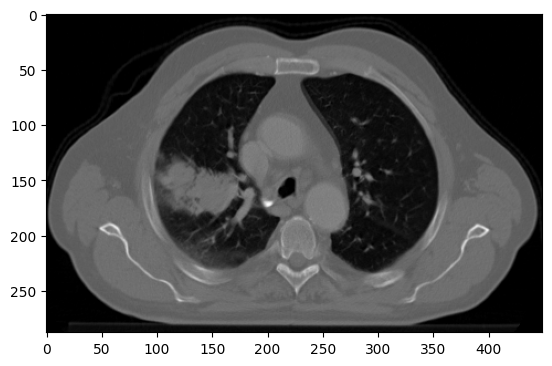

In [6]:
# Plot an image 
img = np.asarray(Image.open('train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000009 (7).png'))
imgplot = plt.imshow(img)

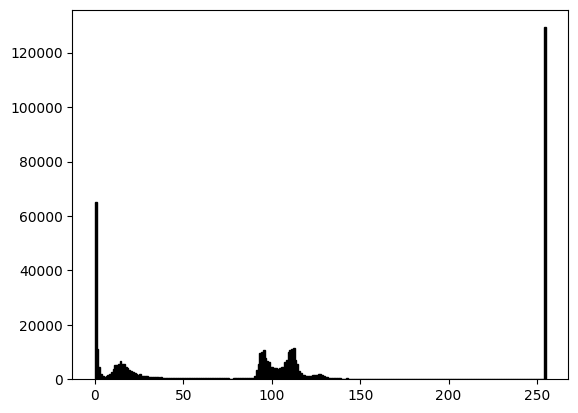

In [7]:
# Check the distibution of the pixels
_ = plt.hist(img.ravel(), bins=range(256), fc='k', ec='k')

In [8]:
# Put the data in datasets, for train val and test

batch_size=32
img_size = (512, 512)

train_ds = tf.keras.utils.image_dataset_from_directory("train", 
                                                       batch_size=batch_size, 
                                                       image_size=img_size, 
                                                       seed=0, 
                                                       label_mode='categorical', 
                                                       shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory("test", # We changed the directory because `test` has more images
                                                     batch_size=batch_size,
                                                     image_size=img_size, 
                                                     seed=0, 
                                                     label_mode='categorical', 
                                                     shuffle=False)

test_ds = tf.keras.utils.image_dataset_from_directory("valid", 
                                                      batch_size=batch_size,
                                                      image_size=img_size,
                                                      seed=0,
                                                      label_mode='categorical',
                                                      shuffle=False)

Found 613 files belonging to 4 classes.
Found 315 files belonging to 4 classes.
Found 72 files belonging to 4 classes.


In [9]:
class_names = train_ds.class_names
print(class_names)

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


In [10]:
# check the dimentions of the training data
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 512, 512, 3)
(32, 4)


In [11]:
def min_max(ds):
    img_batch, labels_batch = next(iter(ds))
    print("Minimum pixel value:",np.min(img_batch[0]), "\nMaximum pixel value:",np.max(img_batch[0]))

min_max(train_ds)

Minimum pixel value: 0.0 
Maximum pixel value: 255.0


To ensure that the performance of the neural network is the best we need to rescale the variable to be in a lower range, or we use a function that expects the range to be 0-255 as is the case in here. 

In [12]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))

In [13]:
ssl._create_default_https_context = ssl._create_unverified_context

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

In [14]:
for layer in base_model.layers:
    layer.trainable = False

In [15]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # Replace num_classes with the number of your classes

model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
20/20 [==============================] - 142s 7s/step - loss: 1.3533 - accuracy: 0.5024 - val_loss: 1.1828 - val_accuracy: 0.5524
Epoch 2/20
20/20 [==============================] - 142s 7s/step - loss: 0.8037 - accuracy: 0.6574 - val_loss: 0.8783 - val_accuracy: 0.5333
Epoch 3/20
20/20 [==============================] - 141s 7s/step - loss: 0.5680 - accuracy: 0.7830 - val_loss: 0.7018 - val_accuracy: 0.6730
Epoch 4/20
20/20 [==============================] - 141s 7s/step - loss: 0.4252 - accuracy: 0.8662 - val_loss: 0.6465 - val_accuracy: 0.7333
Epoch 5/20
20/20 [==============================] - 141s 7s/step - loss: 0.4011 - accuracy: 0.8679 - val_loss: 0.6331 - val_accuracy: 0.7492
Epoch 6/20
20/20 [==============================] - 142s 7s/step - loss: 0.3070 - accuracy: 0.9135 - val_loss: 0.6073 - val_accuracy: 0.7492
Epoch 7/20
20/20 [==============================] - 142s 7s/step - loss: 0.2494 - accuracy: 0.9478 - val_loss: 0.5994 - val_accuracy: 0.7429
Epoch 8/20
20

In [18]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

3/3 [==============================] - 11s 3s/step - loss: 0.3924 - accuracy: 0.8889
Test Loss: 0.3923878073692322
Test Accuracy: 0.8888888955116272
